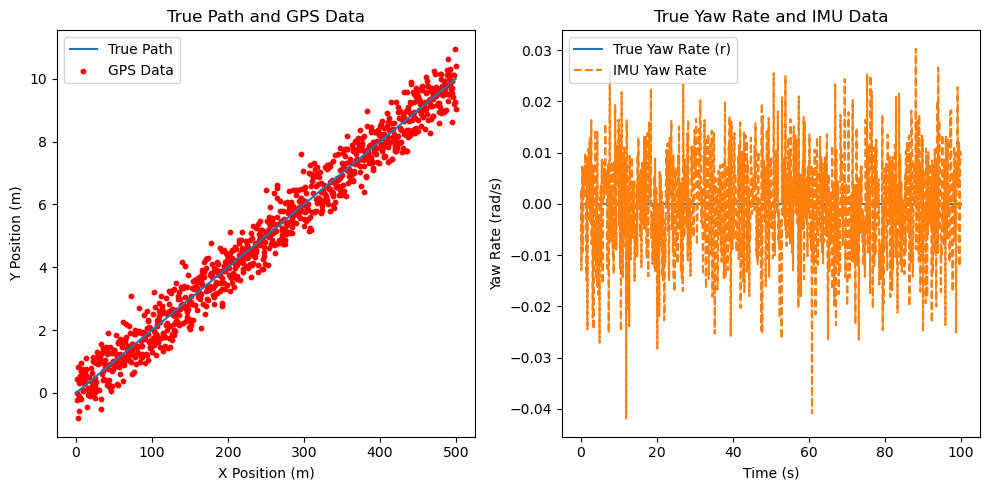

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 시뮬레이션 설정
dt = 0.1  # 시간 간격 (초)
total_time = 100  # 총 시뮬레이션 시간 (초)
num_steps = int(total_time / dt)

# 선박 파라미터
m = 500.0  # 선박 질량 (kg)
I_z = 3000.0  # 선박의 관성 모멘트 (kg*m^2)
X = 0.0  # 외부 힘 (예: 추진력)
Y = 0.0  # 외부 힘 (예: 횡방향 힘)
N = 0.0  # 외부 모멘트 (예: 회전 모멘트)

# 초기 상태
x = 0.0
y = 0.0
psi = 0.0
u = 5.0  # 초기 전진 속도 (m/s)
v = 0.1 # 초기 횡향 속도 (m/s)
r = 0.0

# 상태 벡터 초기화
state = np.array([x, y, psi, u, v, r])
states = [state]

# 센서 노이즈
gps_noise_std = 0.5  # GPS 노이즈 표준편차 (m)
imu_noise_std = 0.01  # IMU 노이즈 표준편차 (rad/s)

# 센서 데이터 저장
gps_data = []
imu_data = []

# 시뮬레이션 루프
for step in range(num_steps):
    # 상태 공간 모델을 통해 다음 상태 계산
    x, y, psi, u, v, r = state
    x_dot = u * np.cos(psi) - v * np.sin(psi)
    y_dot = u * np.sin(psi) + v * np.cos(psi)
    psi_dot = r
    u_dot = (X - Y * r + m * v * r) / m
    v_dot = (Y + X * r - m * u * r) / m
    r_dot = (N - X * v - Y * u) / I_z

    # 다음 상태 업데이트
    state = state + dt * np.array([x_dot, y_dot, psi_dot, u_dot, v_dot, r_dot])
    states.append(state)

    # 현재 상태에서 실제 측정값 계산
    true_x, true_y, true_psi = state[0], state[1], state[2]

    # 센서 데이터 생성 (노이즈 추가)
    gps_x = true_x + np.random.normal(0, gps_noise_std)
    gps_y = true_y + np.random.normal(0, gps_noise_std)
    gps_psi = true_psi + np.random.normal(0, imu_noise_std)
    imu_r = r + np.random.normal(0, imu_noise_std)

    gps_data.append([gps_x, gps_y, gps_psi])
    imu_data.append(imu_r)

# numpy 배열로 변환
states = np.array(states)
gps_data = np.array(gps_data)
imu_data = np.array(imu_data)

# 시뮬레이션 결과 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(states[:, 0], states[:, 1], label='True Path')
plt.scatter(gps_data[:, 0], gps_data[:, 1], color='red', s=10, label='GPS Data')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('True Path and GPS Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(num_steps + 1) * dt, states[:, 5], label='True Yaw Rate (r)')
plt.plot(np.arange(num_steps) * dt, imu_data, label='IMU Yaw Rate', linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Yaw Rate (rad/s)')
plt.title('True Yaw Rate and IMU Data')
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
!pip install filterpy

Defaulting to user installation because normal site-packages is not writeable


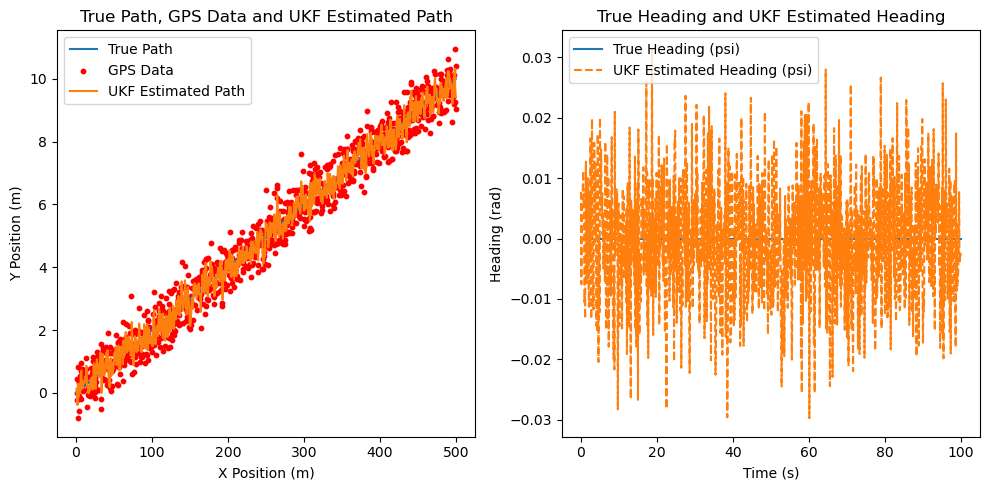

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

# 상태 전이 함수 정의
def fx(state, dt):
    x, y, psi, u, v, r = state
    x_dot = u * np.cos(psi) - v * np.sin(psi)
    y_dot = u * np.sin(psi) + v * np.cos(psi)
    psi_dot = r
    u_dot = 0  # 외부 힘과 모멘트를 사용하지 않음
    v_dot = 0  # 외부 힘과 모멘트를 사용하지 않음
    r_dot = 0  # 외부 힘과 모멘트를 사용하지 않음

    x += x_dot * dt
    y += y_dot * dt
    psi += psi_dot * dt
    u += u_dot * dt
    v += v_dot * dt
    r += r_dot * dt

    return np.array([x, y, psi, u, v, r])

# 측정 함수 정의
def hx(state):
    x, y, psi, u, v, r = state
    return np.array([x, y, psi])

# 초기 상태 및 공분산 행렬 정의
initial_state = np.array([0, 0, 0, 5, 0, 0])
P = np.eye(6) * 0.1

# 시그마 포인트 및 UKF 인스턴스 생성
points = MerweScaledSigmaPoints(n=6, alpha=0.1, beta=2., kappa=-1)
ukf = UKF(dim_x=6, dim_z=3, fx=fx, hx=hx, dt=0.1, points=points)
ukf.x = initial_state
ukf.P = P
ukf.R = np.diag([gps_noise_std**2, gps_noise_std**2, imu_noise_std**2])
ukf.Q = np.eye(6) * 0.1

# UKF를 사용한 상태 추정
estimated_states = []
for k in range(num_steps):
    ukf.predict()
    ukf.update(gps_data[k])
    estimated_states.append(ukf.x.copy())

# numpy 배열로 변환
estimated_states = np.array(estimated_states)

# 시뮬레이션 결과 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(states[:, 0], states[:, 1], label='True Path')
plt.scatter(gps_data[:, 0], gps_data[:, 1], color='red', s=10, label='GPS Data')
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label='UKF Estimated Path')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('True Path, GPS Data and UKF Estimated Path')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(num_steps + 1) * dt, states[:, 2], label='True Heading (psi)')
plt.plot(np.arange(num_steps) * dt, estimated_states[:, 2], label='UKF Estimated Heading (psi)', linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Heading (rad)')
plt.title('True Heading and UKF Estimated Heading')
plt.legend()

plt.tight_layout()
plt.show()


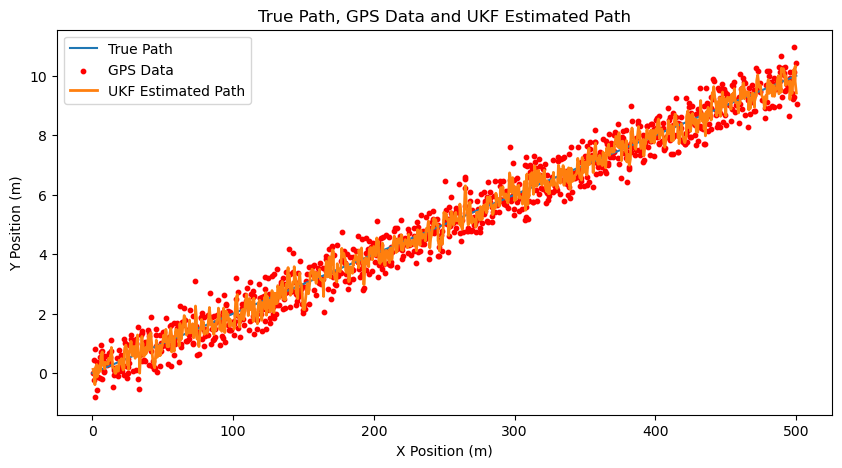

In [6]:
# True Path, GPS Data and UKF Estimated Path만 따로 더 크게 보기
plt.figure(figsize=(10, 5))
plt.plot(states[:, 0], states[:, 1], label='True Path')
plt.scatter(gps_data[:, 0], gps_data[:, 1], color='red', s=10, label='GPS Data')

# UKF 추정 경로를 더 크게 표시
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label='UKF Estimated Path', linewidth=2)
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('True Path, GPS Data and UKF Estimated Path')

plt.legend()

plt.show()

